In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from textwrap import fill
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [13]:
#import play by play data

yrs = [2015, 2016, 2017, 2018, 2019]
df = pd.DataFrame()
temp = pd.DataFrame()

for y in yrs:
    temp = pd.read_csv("nflscrapR-data/play_by_play_data/regular_season/reg_pbp_" + str(y) + ".csv", low_memory=False)
    temp['year'] = y
    df = temp if y == yrs[0] else df.append(temp, ignore_index=True)
        

df.tail()

,play_id,game_id,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,...,penalty_player_name,penalty_yards,replay_or_challenge,replay_or_challenge_result,penalty_type,defensive_two_point_attempt,defensive_two_point_conv,defensive_extra_point_attempt,defensive_extra_point_conv,year
227806,3955,2019122915,SEA,SF,SEA,home,SF,SF,5.0,2019-12-29,...,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0,2019
227807,3977,2019122915,SEA,SF,SEA,home,SF,SF,5.0,2019-12-29,...,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0,2019
227808,3999,2019122915,SEA,SF,SEA,home,SF,SF,5.0,2019-12-29,...,NaN,NaN,1,upheld,NaN,0.0,0.0,0.0,0.0,2019
227809,4080,2019122915,SEA,SF,SF,away,SEA,SF,99.0,2019-12-29,...,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0,2019
227810,4101,2019122915,SEA,SF,NaN,NaN,NaN,SF,NaN,2019-12-29,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,2019


In [18]:
#import game data to identify winner of each game (not in pbp dataset)

games = pd.DataFrame()
temp = pd.DataFrame()
temp.head()
for y in yrs:
    temp = pd.read_csv("nflscrapR-data/games_data/regular_season/reg_games_" + str(y) + ".csv", low_memory=False)
    temp['year'] = y
    games = temp if y == yrs[0] else games.append(temp, ignore_index=True)
        

games.tail()

,type,game_id,home_team,away_team,week,season,state_of_game,game_url,home_score,away_score,year
1275,reg,2019122900,BAL,PIT,17,2019,POST,http://www.nfl.com/liveupdate/game-center/2019...,28,10,2019
1276,reg,2019122907,JAX,IND,17,2019,POST,http://www.nfl.com/liveupdate/game-center/2019...,38,20,2019
1277,reg,2019122913,DEN,OAK,17,2019,POST,http://www.nfl.com/liveupdate/game-center/2019...,16,15,2019
1278,reg,2019122914,LA,ARI,17,2019,POST,http://www.nfl.com/liveupdate/game-center/2019...,31,24,2019
1279,reg,2019122915,SEA,SF,17,2019,POST,http://www.nfl.com/liveupdate/game-center/2019...,21,26,2019


# Data Clean Up

In [19]:
#identify winner 
games['score_diff'] = games['home_score'] - games['away_score']
games['win_team'] = np.where(games['score_diff'] > 0, games['home_team'], games['away_team'])
games['win_team'] = np.where(games['score_diff'] == 0, 'TIE', games['win_team'])
games = games.drop(columns=['score_diff'])

In [20]:
games.shape

(1280, 12)

In [23]:
#map win team to each row in pbp dataset and remove ties for simplicity purposes

df_win = pd.merge(df, games[['game_id','win_team']], how="left", on='game_id')
df_win = df_win[df_win['win_team'] != 'TIE']
df_win.head()

(227811, 258)
(226695, 258)


,play_id,game_id,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,...,penalty_yards,replay_or_challenge,replay_or_challenge_result,penalty_type,defensive_two_point_attempt,defensive_two_point_conv,defensive_extra_point_attempt,defensive_extra_point_conv,year,win_team
0,36,2015091000,NE,PIT,PIT,away,NE,NE,35.0,2015-09-10,...,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0,2015,NE
1,51,2015091000,NE,PIT,PIT,away,NE,PIT,80.0,2015-09-10,...,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0,2015,NE
2,72,2015091000,NE,PIT,PIT,away,NE,PIT,62.0,2015-09-10,...,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0,2015,NE
3,101,2015091000,NE,PIT,PIT,away,NE,PIT,53.0,2015-09-10,...,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0,2015,NE
4,122,2015091000,NE,PIT,PIT,away,NE,NE,49.0,2015-09-10,...,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0,2015,NE


In [26]:
df_win['poswin'] = df_win['posteam'] == df_win['win_team']
df_win['poswin'] = df_win['poswin'].astype(int)
df_win.head()

,play_id,game_id,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,...,replay_or_challenge,replay_or_challenge_result,penalty_type,defensive_two_point_attempt,defensive_two_point_conv,defensive_extra_point_attempt,defensive_extra_point_conv,year,win_team,poswin
0,36,2015091000,NE,PIT,PIT,away,NE,NE,35.0,2015-09-10,...,0,NaN,NaN,0.0,0.0,0.0,0.0,2015,NE,0
1,51,2015091000,NE,PIT,PIT,away,NE,PIT,80.0,2015-09-10,...,0,NaN,NaN,0.0,0.0,0.0,0.0,2015,NE,0
2,72,2015091000,NE,PIT,PIT,away,NE,PIT,62.0,2015-09-10,...,0,NaN,NaN,0.0,0.0,0.0,0.0,2015,NE,0
3,101,2015091000,NE,PIT,PIT,away,NE,PIT,53.0,2015-09-10,...,0,NaN,NaN,0.0,0.0,0.0,0.0,2015,NE,0
4,122,2015091000,NE,PIT,PIT,away,NE,NE,49.0,2015-09-10,...,0,NaN,NaN,0.0,0.0,0.0,0.0,2015,NE,0


# Part 1: Win Probability Model

In [39]:
#remove "NA" downs, which consist of special plays, timeouts, or play clock documentation
#remove "NA" play types, consist of special plays, penalties, etc.

df_na = df_win
df_na = df_na.dropna(subset=['down','play_type'])
df_na.shape

(190761, 259)

In [73]:

data = df_na[['game_id','game_date','posteam','home_team','away_team','qtr','down','ydstogo','game_seconds_remaining',
                'half_seconds_remaining','quarter_seconds_remaining','yardline_100','score_differential','poswin',
                
               #include all play outcomes (binary variables)
                'punt_blocked', 'first_down_rush', 'first_down_pass', 'first_down_penalty', 'third_down_converted', 
                'third_down_failed', 'fourth_down_converted', 'fourth_down_failed', 'incomplete_pass', 'touchback', 
                'interception', 'punt_inside_twenty', 'punt_in_endzone', 'punt_out_of_bounds', 'punt_downed', 
                'punt_fair_catch', 'kickoff_inside_twenty', 'kickoff_in_endzone', 'kickoff_out_of_bounds', 
                'kickoff_downed', 'kickoff_fair_catch', 'fumble_forced', 'fumble_not_forced', 'fumble_out_of_bounds',
                'solo_tackle', 'safety', 'penalty', 'tackled_for_loss', 'fumble_lost', 'own_kickoff_recovery', 
                'own_kickoff_recovery_td', 'qb_hit', 'rush_attempt', 'pass_attempt', 'sack', 'touchdown', 'pass_touchdown', 
                'rush_touchdown', 'return_touchdown', 'extra_point_attempt', 'two_point_attempt', 'field_goal_attempt', 
                'kickoff_attempt', 'punt_attempt', 'fumble', 'complete_pass', 'assist_tackle', 'lateral_reception', 
                'lateral_rush', 'lateral_return', 'lateral_recovery'
                  ]]

data = pd.get_dummies(data, columns=['qtr','down'])
data = data.drop(columns=['qtr_1','down_1.0'])
data = data.reset_index(drop=True)
data.head()

,game_id,game_date,posteam,home_team,away_team,ydstogo,game_seconds_remaining,half_seconds_remaining,quarter_seconds_remaining,yardline_100,...,lateral_rush,lateral_return,lateral_recovery,qtr_2,qtr_3,qtr_4,qtr_5,down_2.0,down_3.0,down_4.0
0,2015091000,2015-09-10,PIT,NE,PIT,10,3600.0,1800.0,900.0,80.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,2015091000,2015-09-10,PIT,NE,PIT,10,3561.0,1761.0,861.0,62.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,2015091000,2015-09-10,PIT,NE,PIT,1,3544.0,1744.0,844.0,53.0,...,0.0,0.0,0.0,0,0,0,0,1,0,0
3,2015091000,2015-09-10,PIT,NE,PIT,10,3506.0,1706.0,806.0,49.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
4,2015091000,2015-09-10,PIT,NE,PIT,10,3462.0,1662.0,762.0,35.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


## Basic / Simple Logit Model

In [154]:
# simiple logit model
# split data into train/test

y = data['poswin']
x = data[['qtr_2','qtr_3','qtr_4','qtr_5','down_2.0','down_3.0','down_4.0','ydstogo','game_seconds_remaining',
          'yardline_100','score_differential']]

tstpct = .2
x_train,x_test,y_train,y_test=train_test_split(x,y, test_size=tstpct)

X = x_train
Y = y_train
X2 = x_test
Y2_b = y_test
 
    
# prediction with sklearn
regr = linear_model.LogisticRegression()
regr.fit(X, Y)

train = regr.predict_proba(X)
train_auc = roc_auc_score(Y, train[:,1])

basic = regr.predict_proba(X2)
basic_auc = roc_auc_score(Y2_b, basic[:,1])

print('Train Prediction: AUROC = %.3f' % (train_auc))
print('Test Prediction: AUROC = %.3f' % (basic_auc))




# with statsmodels

model = sm.Logit(Y, X)
result = model.fit()
# predictions = model.predict(X2) 
 
print_model = result.summary()
print(print_model)

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Train Prediction: AUROC = 0.846
Test Prediction: AUROC = 0.846
Optimization terminated successfully.
         Current function value: 0.479690
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 poswin   No. Observations:               152608
Model:                          Logit   Df Residuals:                   152597
Method:                           MLE   Df Model:                           10
Date:                Sat, 22 Aug 2020   Pseudo R-squ.:                  0.3079
Time:                        23:10:14   Log-Likelihood:                -73205.
converged:                       True   LL-Null:                   -1.0577e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
qtr_2                

## Check Multicollinearity of Independent Variables

In [74]:
# test multicollinearity of remaining variables
# VIF exceeding 5-10 indicates high multicollinearity
ind_vars = data.drop(columns=['game_id','game_date','posteam','home_team','away_team','poswin']).columns.tolist()
ind_vars


def calc_vif(X):
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return(vif)

X = data[ind_vars]
full_vif = calc_vif(X)


C:\Users\shrut\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\shrut\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


In [75]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

In [76]:
full_vif = pd.DataFrame.sort_values(full_vif, by='VIF', ascending=False)
print_full(full_vif)


                    variables         VIF
51              complete_pass         inf
1      game_seconds_remaining         inf
2      half_seconds_remaining         inf
3   quarter_seconds_remaining         inf
16               interception         inf
40                       sack         inf
58                      qtr_3         inf
57                      qtr_2         inf
14            incomplete_pass         inf
39               pass_attempt         inf
50                     fumble  283.371311
27              fumble_forced  188.300262
28          fumble_not_forced   98.645317
41                  touchdown   41.502877
42             pass_touchdown   27.499202
38               rush_attempt   25.578648
59                      qtr_4   23.889194
63                   down_4.0   15.445699
49               punt_attempt   15.181179
43             rush_touchdown   14.939466
62                   down_3.0   12.675984
30                solo_tackle   10.680821
11          third_down_failed    8

In [77]:
# iterative process to select which variables with high multicollinearity to remove
drop_vars = ['game_seconds_remaining','pass_attempt','kickoff_inside_twenty','kickoff_in_endzone',
             'kickoff_downed','kickoff_fair_catch','own_kickoff_recovery','own_kickoff_recovery_td','extra_point_attempt',
             'two_point_attempt','kickoff_attempt']
ind_vars = [v for v in ind_vars if v not in drop_vars]

filt_vif = calc_vif(data[ind_vars])
filt_vif = pd.DataFrame.sort_values(filt_vif, by='VIF', ascending=False)
print_full(filt_vif)

C:\Users\shrut\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


                    variables         VIF
39                     fumble  283.371311
22              fumble_forced  188.300262
1      half_seconds_remaining  109.816743
23          fumble_not_forced   98.645317
33                  touchdown   41.502877
2   quarter_seconds_remaining   35.279709
34             pass_touchdown   27.499202
31               rush_attempt   25.578648
40              complete_pass   24.760138
46                      qtr_2   24.014129
48                      qtr_4   23.889194
52                   down_4.0   15.445699
38               punt_attempt   15.181179
35             rush_touchdown   14.939466
51                   down_3.0   12.675984
13            incomplete_pass   10.783137
25                solo_tackle   10.680821
10          third_down_failed    8.798866
9        third_down_converted    6.403886
41              assist_tackle    5.722538
37         field_goal_attempt    5.558698
32                       sack    5.328910
27                    penalty    4

In [78]:
drop_vars.extend(['fumble','half_seconds_remaining'])
ind_vars = [v for v in ind_vars if v not in drop_vars]

filt_vif = calc_vif(data[ind_vars])
filt_vif = pd.DataFrame.sort_values(filt_vif, by='VIF', ascending=False)
print_full(filt_vif)

C:\Users\shrut\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1687: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


                    variables        VIF
32                  touchdown  42.944853
33             pass_touchdown  28.072009
24                solo_tackle  22.232488
30               rush_attempt  19.692171
38              complete_pass  19.231733
50                   down_4.0  16.716902
34             rush_touchdown  15.092217
37               punt_attempt  15.020184
49                   down_3.0  14.401010
9           third_down_failed   9.278825
2                yardline_100   6.710588
39              assist_tackle   6.638663
8        third_down_converted   6.549467
0                     ydstogo   6.463691
36         field_goal_attempt   4.742079
31                       sack   3.654611
12            incomplete_pass   3.557503
1   quarter_seconds_remaining   3.510243
6             first_down_pass   2.853133
35           return_touchdown   2.804975
19            punt_fair_catch   2.464443
26                    penalty   2.373746
21              fumble_forced   2.333745
28              

In [79]:
drop_vars.extend(['touchdown','down_4.0','down_3.0']) #third_down_failed vs. third_down_converted covers explains 3rd and 4th down
ind_vars = [v for v in ind_vars if v not in drop_vars]

filt_vif = calc_vif(data[ind_vars])
filt_vif = pd.DataFrame.sort_values(filt_vif, by='VIF', ascending=False)
print_full(filt_vif)

C:\Users\shrut\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1687: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


                    variables        VIF
24                solo_tackle  22.188149
30               rush_attempt  19.643404
37              complete_pass  19.197509
2                yardline_100   6.674983
38              assist_tackle   6.627824
0                     ydstogo   6.459259
36               punt_attempt   5.660921
31                       sack   3.646952
12            incomplete_pass   3.550853
1   quarter_seconds_remaining   3.497839
6             first_down_pass   2.853100
19            punt_fair_catch   2.462583
21              fumble_forced   2.332179
28                fumble_lost   2.173875
45                      qtr_4   2.164730
43                      qtr_2   2.158489
26                    penalty   2.149953
32             pass_touchdown   2.015283
15         punt_inside_twenty   1.982054
44                      qtr_3   1.957731
29                     qb_hit   1.842379
47                   down_2.0   1.800913
18                punt_downed   1.784478
22          fumb

In [80]:
drop_vars.extend(['solo_tackle','rush_attempt','kickoff_out_of_bounds'])
ind_vars = [v for v in ind_vars if v not in drop_vars]

filt_vif = calc_vif(data[ind_vars])
filt_vif = pd.DataFrame.sort_values(filt_vif, by='VIF', ascending=False)
print_full(filt_vif)

                    variables       VIF
2                yardline_100  5.801149
0                     ydstogo  5.288503
34              complete_pass  3.564306
1   quarter_seconds_remaining  3.174655
6             first_down_pass  2.840049
33               punt_attempt  2.811398
20              fumble_forced  2.321614
26                fumble_lost  2.173051
15         punt_inside_twenty  1.978556
28                       sack  1.968651
40                      qtr_2  1.960273
42                      qtr_4  1.948374
12            incomplete_pass  1.875048
19            punt_fair_catch  1.851625
27                     qb_hit  1.842368
41                      qtr_3  1.819326
21          fumble_not_forced  1.738042
44                   down_2.0  1.700806
24                    penalty  1.678871
5             first_down_rush  1.591909
39           lateral_recovery  1.576246
8        third_down_converted  1.557915
18                punt_downed  1.475056
7          first_down_penalty  1.453305


## Comprehensive Logit Model with Game Play Binary Variables

In [102]:
#add game seconds back in because prior iteration had me remove all time-based variables (seconds, quarters)
drop_vars.remove('game_seconds_remaining')

filt_data = data.drop(columns=drop_vars)

In [103]:
# split data into train/test

y = filt_data['poswin']
x = filt_data.drop(columns=['game_id','game_date','posteam','home_team','away_team','poswin'])

tstpct = .2
x_train,x_test,y_train,y_test=train_test_split(x,y, test_size=tstpct)


X = x_train
Y = y_train
X2 = x_test
Y2 = y_test
 
    
# prediction with sklearn
regr = linear_model.LogisticRegression()
regr.fit(X, Y)
predictions = regr.predict(X2)
prediction_error = y_test - predictions

print ('R-squared (Train): ',  regr.score(X, Y))
print ('R-squared (Test): ',  regr.score(X2, Y2))



# with statsmodels
# X = sm.add_constant(X) # adding a constant

model = sm.Logit(Y, X)
result = model.fit()
# predictions = model.predict(X2) 
 
print_model = result.summary()
print(print_model)

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


R-squared (Train):  0.7601108723002726
R-squared (Test):  0.7607789688884229
Optimization terminated successfully.
         Current function value: 0.475704
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 poswin   No. Observations:               152608
Model:                          Logit   Df Residuals:                   152562
Method:                           MLE   Df Model:                           45
Date:                Sat, 22 Aug 2020   Pseudo R-squ.:                  0.3136
Time:                        16:21:12   Log-Likelihood:                -72596.
converged:                       True   LL-Null:                   -1.0577e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
y

In [104]:
#remove variable based on insignificant p-values
drop_vars.extend(['punt_blocked','touchback','punt_inside_twenty','punt_in_endzone','punt_out_of_bounds', 'punt_fair_catch',
                  'fumble_out_of_bounds','safety','qb_hit', 'assist_tackle','lateral_rush','lateral_return'])
filt_data = data.drop(columns=drop_vars)

In [106]:
# split data into train/test

y = filt_data['poswin']
x = filt_data.drop(columns=['game_id','game_date','posteam','home_team','away_team','poswin'])

tstpct = .2
x_train,x_test,y_train,y_test=train_test_split(x,y, test_size=tstpct)


# use in linear regression model

X = x_train
Y = y_train
X2 = x_test
Y2 = y_test
 
    
# prediction with sklearn
regr = linear_model.LogisticRegression()
regr.fit(X, Y)
predictions = regr.predict(X2)
prediction_error = y_test - predictions

print ('R-squared (Train): ',  regr.score(X, Y))
print ('R-squared (Test): ',  regr.score(X2, Y2))



# with statsmodels
# X = sm.add_constant(X) # adding a constant

model = sm.Logit(Y, X)
result = model.fit()
# predictions = model.predict(X2) 
 
print_model = result.summary()
print(print_model)

R-squared (Train):  0.7592393583560495
R-squared (Test):  0.7647105076927109
Optimization terminated successfully.
         Current function value: 0.476914
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 poswin   No. Observations:               152608
Model:                          Logit   Df Residuals:                   152574
Method:                           MLE   Df Model:                           33
Date:                Sat, 22 Aug 2020   Pseudo R-squ.:                  0.3119
Time:                        16:23:33   Log-Likelihood:                -72781.
converged:                       True   LL-Null:                   -1.0577e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
y

In [107]:
drop_vars.extend(['ydstogo','fourth_down_converted','punt_downed','fumble_not_forced'])
filt_data = data.drop(columns=drop_vars)

In [153]:
# split data into train/test

y = filt_data['poswin']
x = filt_data.drop(columns=['game_id','game_date','posteam','home_team','away_team','poswin'])

tstpct = .2
x_train,x_test,y_train,y_test=train_test_split(x,y, test_size=tstpct)


# use in linear regression model

X = x_train
Y = y_train
X2 = x_test
Y2 = y_test
 
    
# prediction with sklearn
regr = linear_model.LogisticRegression()
regr.fit(X, Y)
predictions = regr.predict(X2)
prediction_error = y_test - predictions

print ('R-squared (Train): ',  regr.score(X, Y))
print ('R-squared (Test): ',  regr.score(X2, Y2))



# with statsmodels
# X = sm.add_constant(X) # adding a constant

model = sm.Logit(Y, X)
result = model.fit()
# predictions = model.predict(X2) 
 
print_model = result.summary()
print(print_model)

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


R-squared (Train):  0.7602812434472636
R-squared (Test):  0.7628757895840432
Optimization terminated successfully.
         Current function value: 0.476356
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 poswin   No. Observations:               152608
Model:                          Logit   Df Residuals:                   152580
Method:                           MLE   Df Model:                           27
Date:                Sat, 22 Aug 2020   Pseudo R-squ.:                  0.3127
Time:                        23:09:27   Log-Likelihood:                -72696.
converged:                       True   LL-Null:                   -1.0577e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
g

In [113]:
drop_vars.extend(['fumble_lost'])
filt_data = data.drop(columns=drop_vars)

In [114]:
# split data into train/test

y = filt_data['poswin']
x = filt_data.drop(columns=['game_id','game_date','posteam','home_team','away_team','poswin'])

tstpct = .2
x_train,x_test,y_train,y_test=train_test_split(x,y, test_size=tstpct)


# use in linear regression model

X = x_train
Y = y_train
X2 = x_test
Y2 = y_test
 
    
# prediction with sklearn
regr = linear_model.LogisticRegression()
regr.fit(X, Y)
predictions = regr.predict(X2)
prediction_error = y_test - predictions

print ('R-squared (Train): ',  regr.score(X, Y))
print ('R-squared (Test): ',  regr.score(X2, Y2))



# with statsmodels
# X = sm.add_constant(X) # adding a constant

model = sm.Logit(Y, X)
result = model.fit()
# predictions = model.predict(X2) 
 
print_model = result.summary()
print(print_model)

R-squared (Train):  0.7596914971692179
R-squared (Test):  0.7625612664797001
Optimization terminated successfully.
         Current function value: 0.477336
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 poswin   No. Observations:               152608
Model:                          Logit   Df Residuals:                   152579
Method:                           MLE   Df Model:                           28
Date:                Sat, 22 Aug 2020   Pseudo R-squ.:                  0.3113
Time:                        16:27:58   Log-Likelihood:                -72845.
converged:                       True   LL-Null:                   -1.0577e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
g

In [115]:
drop_vars.extend(['lateral_recovery'])
filt_data = data.drop(columns=drop_vars)

In [158]:
# split data into train/test
y = filt_data['poswin']
x = filt_data.drop(columns=['game_id','game_date','posteam','home_team','away_team','poswin'])

tstpct = .2
x_train,x_test,y_train,y_test=train_test_split(x,y, test_size=tstpct)

X = x_train
Y = y_train
X2 = x_test
Y2 = y_test
 
    
# prediction with sklearn
regr = linear_model.LogisticRegression()
regr.fit(X, Y)

train = regr.predict_proba(X)
train_auc = roc_auc_score(Y, train[:,1])

pred = regr.predict_proba(X2)
pred_auc = roc_auc_score(Y2, pred[:,1])

print('Train Prediction: AUROC = %.3f' % (train_auc))
print('Test Prediction: AUROC = %.3f' % (pred_auc))


# with statsmodels

model = sm.Logit(Y, X)
result = model.fit()
 
print_model = result.summary()
print(print_model)

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Train Prediction: AUROC = 0.849
Test Prediction: AUROC = 0.847
Optimization terminated successfully.
         Current function value: 0.476000
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 poswin   No. Observations:               152608
Model:                          Logit   Df Residuals:                   152580
Method:                           MLE   Df Model:                           27
Date:                Sat, 22 Aug 2020   Pseudo R-squ.:                  0.3132
Time:                        23:11:07   Log-Likelihood:                -72641.
converged:                       True   LL-Null:                   -1.0577e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
game_seconds_re

In [173]:
rand = [0 for _ in range(len(Y2))]
pred = regr.predict_proba(X2)

pred_1 = pred[:,1]

rand_auc = roc_auc_score(Y2, rand)
pred_auc = roc_auc_score(Y2, pred_1)

print('Random Prediction: AUROC = %.3f' % (rand_auc))
print('Basic Logistic Prediction: AUROC = %.3f' % (basic_auc))
print('Intricate Logistic Prediction: AUROC = %.3f' % (pred_auc))

Random Prediction: AUROC = 0.500
Basic Logistic Prediction: AUROC = 0.846
Intricate Logistic Prediction: AUROC = 0.847


In [160]:
r_fpr, r_tpr, _ = roc_curve(Y2, rand)
p_fpr, p_tpr, _ = roc_curve(Y2, pred)

<function matplotlib.pyplot.show(*args, **kw)>

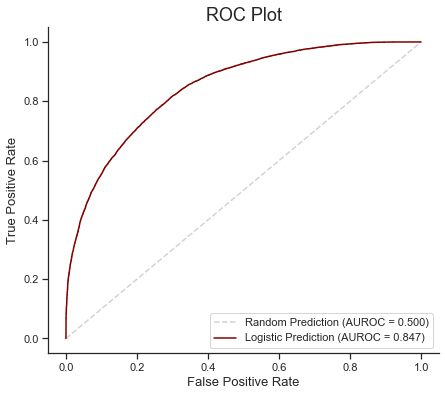

In [167]:
sns.set(rc={'figure.figsize':(7,6)})
sns.set_style("ticks")

plt.plot(r_fpr, r_tpr, linestyle='--', c='lightgrey', label='Random Prediction (AUROC = %.3f)' % rand_auc)
plt.plot(p_fpr, p_tpr, c='maroon', label='Logistic Prediction (AUROC = %.3f)' % pred_auc)
sns.despine()

plt.title('ROC Plot', fontsize=18)
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.legend()

plt.savefig('figures/Logit ROC Curve.png', bbox_inches='tight')
plt.show

# Game Summary

In [230]:
#concatenate win probability predictions

x_train['WP'] = train[:,1]
x_test['WP'] = pred[:,1]
full_predictions = pd.concat([x_train, x_test], axis=0)

WP_data = pd.merge(data, full_predictions['WP'], how='left', left_index=True, right_index=True)
# print(full_predictions.loc[0,])
WP_data.head()


C:\Users\shrut\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\shrut\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,game_id,game_date,posteam,home_team,away_team,ydstogo,game_seconds_remaining,half_seconds_remaining,quarter_seconds_remaining,yardline_100,...,lateral_return,lateral_recovery,qtr_2,qtr_3,qtr_4,qtr_5,down_2.0,down_3.0,down_4.0,WP
0,2015091000,2015-09-10,PIT,NE,PIT,10,3600.0,1800.0,900.0,80.0,...,0.0,0.0,0,0,0,0,0,0,0,0.594041
1,2015091000,2015-09-10,PIT,NE,PIT,10,3561.0,1761.0,861.0,62.0,...,0.0,0.0,0,0,0,0,0,0,0,0.545435
2,2015091000,2015-09-10,PIT,NE,PIT,1,3544.0,1744.0,844.0,53.0,...,0.0,0.0,0,0,0,0,1,0,0,0.624467
3,2015091000,2015-09-10,PIT,NE,PIT,10,3506.0,1706.0,806.0,49.0,...,0.0,0.0,0,0,0,0,0,0,0,0.627074
4,2015091000,2015-09-10,PIT,NE,PIT,10,3462.0,1662.0,762.0,35.0,...,0.0,0.0,0,0,0,0,0,0,0,0.671667


In [231]:
#filter for falcons
team = 'ATL'
atl = pd.concat([WP_data[WP_data['home_team'] == team], WP_data[WP_data['away_team'] == team]], axis=0)

atl.head()

,game_id,game_date,posteam,home_team,away_team,ydstogo,game_seconds_remaining,half_seconds_remaining,quarter_seconds_remaining,yardline_100,...,lateral_return,lateral_recovery,qtr_2,qtr_3,qtr_4,qtr_5,down_2.0,down_3.0,down_4.0,WP
2059,2015091400,2015-09-14,PHI,ATL,PHI,10,3600.0,1800.0,900.0,80.0,...,0.0,0.0,0,0,0,0,0,0,0,0.512479
2060,2015091400,2015-09-14,PHI,ATL,PHI,8,3585.0,1785.0,885.0,78.0,...,0.0,0.0,0,0,0,0,1,0,0,0.506397
2061,2015091400,2015-09-14,PHI,ATL,PHI,6,3554.0,1754.0,854.0,76.0,...,0.0,0.0,0,0,0,0,0,1,0,0.417738
2062,2015091400,2015-09-14,PHI,ATL,PHI,6,3550.0,1750.0,850.0,76.0,...,0.0,0.0,0,0,0,0,0,0,1,0.436509
2063,2015091400,2015-09-14,ATL,ATL,PHI,10,3539.0,1739.0,839.0,75.0,...,0.0,0.0,0,0,0,0,0,0,0,0.530498


In [232]:
#focus on 9/15/19 game vs. PHL, ATL won 24-20

date = '2019-09-15'

game = atl[atl['game_date'] == date]
game['sec'] = 3600 - game['game_seconds_remaining']
game['ATL_WP'] = np.where(game['posteam'] == team, game['WP'], 1 - game['WP'])
game

C:\Users\shrut\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\shrut\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,game_id,game_date,posteam,home_team,away_team,ydstogo,game_seconds_remaining,half_seconds_remaining,quarter_seconds_remaining,yardline_100,...,qtr_2,qtr_3,qtr_4,qtr_5,down_2.0,down_3.0,down_4.0,WP,sec,ATL_WP
157086,2019091513,2019-09-15,ATL,ATL,PHI,10,3600.0,1800.0,900.0,75.0,...,0,0,0,0,0,0,0,0.528902,0.0,0.528902
157087,2019091513,2019-09-15,ATL,ATL,PHI,7,3566.0,1766.0,866.0,72.0,...,0,0,0,0,1,0,0,0.569350,34.0,0.569350
157088,2019091513,2019-09-15,ATL,ATL,PHI,10,3540.0,1740.0,840.0,63.0,...,0,0,0,0,0,0,0,0.551694,60.0,0.551694
157089,2019091513,2019-09-15,ATL,ATL,PHI,4,3507.0,1707.0,807.0,57.0,...,0,0,0,0,1,0,0,0.596823,93.0,0.596823
157090,2019091513,2019-09-15,ATL,ATL,PHI,10,3466.0,1666.0,766.0,51.0,...,0,0,0,0,0,0,0,0.574630,134.0,0.574630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157238,2019091513,2019-09-15,PHI,ATL,PHI,10,71.0,71.0,71.0,18.0,...,0,0,1,0,0,0,0,0.425780,3529.0,0.574220
157239,2019091513,2019-09-15,PHI,ATL,PHI,10,66.0,66.0,66.0,18.0,...,0,0,1,0,1,0,0,0.438736,3534.0,0.561264
157240,2019091513,2019-09-15,PHI,ATL,PHI,8,42.0,42.0,42.0,16.0,...,0,0,1,0,0,1,0,0.360200,3558.0,0.639800
157241,2019091513,2019-09-15,PHI,ATL,PHI,8,38.0,38.0,38.0,16.0,...,0,0,1,0,0,0,1,0.418144,3562.0,0.581856


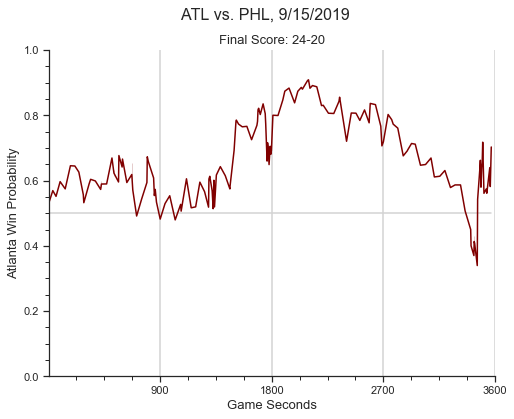

In [233]:
#plot line graph of ATL win probability over time

#quarters in seconds
major = [900,1800,2700,3600]

sns.set(rc={'figure.figsize':(8,6)})
sns.set_style("ticks")
fig = plt.figure()
ax = fig.add_subplot(111)

sns.lineplot(x='sec',y=0.5, data=game, color='lightgrey')
plt.plot([major[0],major[0]], [0, 1], c='lightgrey')
plt.plot([major[1],major[1]], [0, 1], c='lightgrey')
plt.plot([major[2],major[2]], [0, 1], c='lightgrey')
plt.plot([major[3],major[3]], [0, 1], c='lightgrey')
sns.lineplot(x='sec',y='ATL_WP', data=game, color='maroon')
sns.despine()



plt.xlabel('Game Seconds', fontsize= 13)
plt.ylabel('Atlanta Win Probability', fontsize= 13)
plt.xlim(0,3600)
# ax.xaxis.set_major_locator(FixedLocator(major))
plt.ylim(0,1)

plt.xticks(major)
ax.minorticks_on()

plt.suptitle('ATL vs. PHL, 9/15/2019', fontsize= 16)
plt.title('Final Score: 24-20', fontsize= 13)

plt.savefig(fname='figures/ATL v PHL Game', bbox_inches='tight')

# Overall Stats

In [259]:
# atl['year'] = atl['game_date'].str[:4].astype(str)
atl['year'] = pd.DatetimeIndex(atl['game_date']).year
atl['ATL_WP'] = np.where(atl['posteam'] == team, atl['WP'], 1 - atl['WP'])
atl['location'] = np.where(atl['home_team'] == team, 'home', 'away')
atl.head()

,game_id,game_date,posteam,home_team,away_team,ydstogo,game_seconds_remaining,half_seconds_remaining,quarter_seconds_remaining,yardline_100,...,qtr_3,qtr_4,qtr_5,down_2.0,down_3.0,down_4.0,WP,year,ATL_WP,location
2059,2015091400,2015-09-14,PHI,ATL,PHI,10,3600.0,1800.0,900.0,80.0,...,0,0,0,0,0,0,0.512479,2015,0.487521,home
2060,2015091400,2015-09-14,PHI,ATL,PHI,8,3585.0,1785.0,885.0,78.0,...,0,0,0,1,0,0,0.506397,2015,0.493603,home
2061,2015091400,2015-09-14,PHI,ATL,PHI,6,3554.0,1754.0,854.0,76.0,...,0,0,0,0,1,0,0.417738,2015,0.582262,home
2062,2015091400,2015-09-14,PHI,ATL,PHI,6,3550.0,1750.0,850.0,76.0,...,0,0,0,0,0,1,0.436509,2015,0.563491,home
2063,2015091400,2015-09-14,ATL,ATL,PHI,10,3539.0,1739.0,839.0,75.0,...,0,0,0,0,0,0,0.530498,2015,0.530498,home


In [260]:
atl.columns

Index(['game_id', 'game_date', 'posteam', 'home_team', 'away_team', 'ydstogo',
       'game_seconds_remaining', 'half_seconds_remaining',
       'quarter_seconds_remaining', 'yardline_100', 'score_differential',
       'poswin', 'punt_blocked', 'first_down_rush', 'first_down_pass',
       'first_down_penalty', 'third_down_converted', 'third_down_failed',
       'fourth_down_converted', 'fourth_down_failed', 'incomplete_pass',
       'touchback', 'interception', 'punt_inside_twenty', 'punt_in_endzone',
       'punt_out_of_bounds', 'punt_downed', 'punt_fair_catch',
       'kickoff_inside_twenty', 'kickoff_in_endzone', 'kickoff_out_of_bounds',
       'kickoff_downed', 'kickoff_fair_catch', 'fumble_forced',
       'fumble_not_forced', 'fumble_out_of_bounds', 'solo_tackle', 'safety',
       'penalty', 'tackled_for_loss', 'fumble_lost', 'own_kickoff_recovery',
       'own_kickoff_recovery_td', 'qb_hit', 'rush_attempt', 'pass_attempt',
       'sack', 'touchdown', 'pass_touchdown', 'rush_touch

In [261]:
atl_off = atl[atl['posteam'] == team]
atl_off.head()

,game_id,game_date,posteam,home_team,away_team,ydstogo,game_seconds_remaining,half_seconds_remaining,quarter_seconds_remaining,yardline_100,...,qtr_3,qtr_4,qtr_5,down_2.0,down_3.0,down_4.0,WP,year,ATL_WP,location
2063,2015091400,2015-09-14,ATL,ATL,PHI,10,3539.0,1739.0,839.0,75.0,...,0,0,0,0,0,0,0.530498,2015,0.530498,home
2064,2015091400,2015-09-14,ATL,ATL,PHI,7,3507.0,1707.0,807.0,72.0,...,0,0,0,1,0,0,0.570869,2015,0.570869,home
2065,2015091400,2015-09-14,ATL,ATL,PHI,10,3474.0,1674.0,774.0,55.0,...,0,0,0,0,0,0,0.617820,2015,0.617820,home
2066,2015091400,2015-09-14,ATL,ATL,PHI,10,3438.0,1638.0,738.0,30.0,...,0,0,0,0,0,0,0.611422,2015,0.611422,home
2067,2015091400,2015-09-14,ATL,ATL,PHI,1,3406.0,1606.0,706.0,21.0,...,0,0,0,1,0,0,0.616708,2015,0.616708,home


In [288]:
atl_fg = atl_off[atl_off['field_goal_attempt'] == 1]
atl_fg = pd.merge(atl_fg, df_na['field_goal_result'], how='left', 
                  left_on=atl_fg['game_id'].astype(str)+atl_fg['game_seconds_remaining'].astype(str), 
                  right_on=df_na['game_id'].astype(str)+df_na['game_seconds_remaining'].astype(str))
# atl_fg['impact'] = atl_fg['score_differential_post'] - atl_fg['score_differential']
atl_fg.head()

,key_0,game_id,game_date,posteam,home_team,away_team,ydstogo,game_seconds_remaining,half_seconds_remaining,quarter_seconds_remaining,...,qtr_4,qtr_5,down_2.0,down_3.0,down_4.0,WP,year,ATL_WP,location,field_goal_result
0,20150914003360.0,2015091400,2015-09-14,ATL,ATL,PHI,3,3360.0,1560.0,660.0,...,0,0,0,0,1,0.603420,2015,0.603420,home,made
1,20150914001869.0,2015091400,2015-09-14,ATL,ATL,PHI,7,1869.0,69.0,69.0,...,0,0,0,0,1,0.865707,2015,0.865707,home,made
2,2015091400654.0,2015091400,2015-09-14,ATL,ATL,PHI,6,654.0,654.0,654.0,...,1,0,0,0,1,0.726589,2015,0.726589,home,made
3,2015091400393.0,2015091400,2015-09-14,ATL,ATL,PHI,3,393.0,393.0,393.0,...,1,0,0,0,1,0.555133,2015,0.555133,home,made
4,20151011032232.0,2015101103,2015-10-11,ATL,ATL,WAS,9,2232.0,432.0,432.0,...,0,0,0,0,1,0.296715,2015,0.296715,home,made


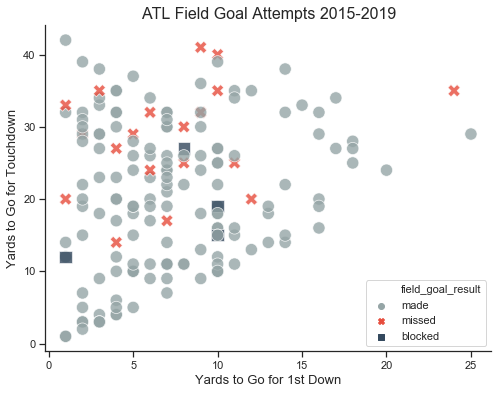

In [298]:

sns.set(rc={'figure.figsize':(8,6)})
sns.set_style("ticks")

cp = ["#95a5a6","#e74c3c", "#34495e"]
sns.set_palette(cp)

sns.scatterplot(data=atl_fg, y="yardline_100", x="ydstogo", hue='field_goal_result', style='field_goal_result', 
                s=150, alpha=0.8)

sns.despine()
plt.title('ATL Field Goal Attempts 2015-2019', fontsize=16)
plt.xlabel('Yards to Go for 1st Down', fontsize=13)
plt.ylabel('Yards to Go for Touchdown', fontsize=13)

plt.savefig(fname='figures/Field Goal Attempts', bbox_inches='tight')

In [324]:
fg = pd.pivot_table(atl_fg, index='field_goal_result', values='field_goal_attempt', aggfunc='count')
fg

,field_goal_attempt
field_goal_result,
blocked,4
made,150
missed,19


In [306]:
atl_4 = atl_off[atl_off['down_4.0'] == 1]
atl_4 = pd.merge(atl_4, df_na['play_type'], how='left', 
                  left_on=atl_4['game_id'].astype(str)+atl_4['game_seconds_remaining'].astype(str), 
                  right_on=df_na['game_id'].astype(str)+df_na['game_seconds_remaining'].astype(str))

atl_4.head()

,key_0,game_id,game_date,posteam,home_team,away_team,ydstogo,game_seconds_remaining,half_seconds_remaining,quarter_seconds_remaining,...,qtr_4,qtr_5,down_2.0,down_3.0,down_4.0,WP,year,ATL_WP,location,play_type
0,20150914003360.0,2015091400,2015-09-14,ATL,ATL,PHI,3,3360.0,1560.0,660.0,...,0,0,0,0,1,0.603420,2015,0.603420,home,field_goal
1,20150914002938.0,2015091400,2015-09-14,ATL,ATL,PHI,15,2938.0,1138.0,238.0,...,0,0,0,0,1,0.578433,2015,0.578433,home,punt
2,20150914002191.0,2015091400,2015-09-14,ATL,ATL,PHI,3,2191.0,391.0,391.0,...,0,0,0,0,1,0.749224,2015,0.749224,home,punt
3,20150914001869.0,2015091400,2015-09-14,ATL,ATL,PHI,7,1869.0,69.0,69.0,...,0,0,0,0,1,0.865707,2015,0.865707,home,field_goal
4,20150914001499.0,2015091400,2015-09-14,ATL,ATL,PHI,11,1499.0,1499.0,599.0,...,0,0,0,0,1,0.850971,2015,0.850971,home,punt


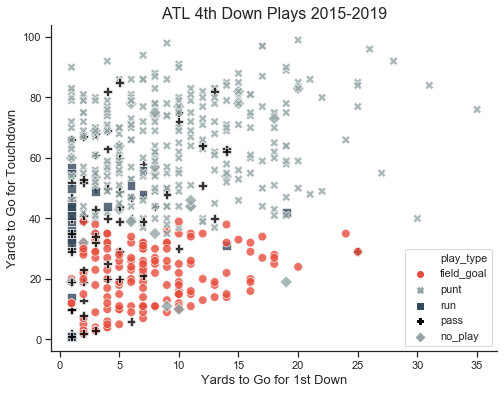

In [313]:

sns.set(rc={'figure.figsize':(8,6)})
sns.set_style("ticks")

cp = ["#e74c3c", "#95a5a6", "#34495e", "#000000",  "#95a5a6",]
sns.set_palette(cp)

sns.scatterplot(data=atl_4, y="yardline_100", x="ydstogo", hue='play_type', style='play_type', 
                s=75, alpha=0.8)

sns.despine()
plt.title('ATL 4th Down Plays 2015-2019', fontsize=16)
plt.xlabel('Yards to Go for 1st Down', fontsize=13)
plt.ylabel('Yards to Go for Touchdown', fontsize=13)

plt.savefig(fname='figures/Fourth Down Plays', bbox_inches='tight')

In [321]:
down_4 = pd.pivot_table(atl_4, index='play_type', values='down_4.0', aggfunc='count')
down_4

,down_4.0
play_type,
field_goal,161
no_play,28
pass,63
punt,277
run,26


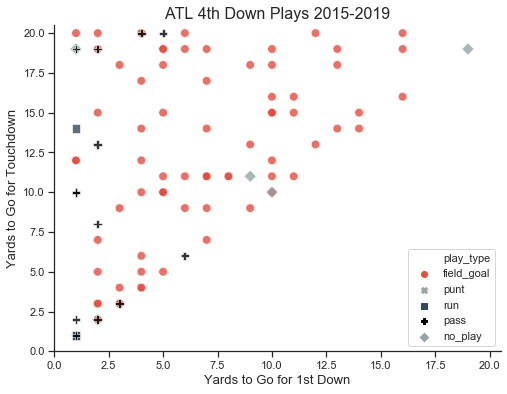

In [318]:
sns.set(rc={'figure.figsize':(8,6)})
sns.set_style("ticks")

cp = ["#e74c3c", "#95a5a6", "#34495e", "#000000",  "#95a5a6",]
sns.set_palette(cp)

sns.scatterplot(data=atl_4, y="yardline_100", x="ydstogo", hue='play_type', style='play_type', 
                s=75, alpha=0.8)

sns.despine()
plt.title('ATL 4th Down Plays 2015-2019', fontsize=16)
plt.xlabel('Yards to Go for 1st Down', fontsize=13)
plt.ylabel('Yards to Go for Touchdown', fontsize=13)
plt.ylim(0,20.5)
plt.xlim(0,20.5)

plt.savefig(fname='figures/Fourth Down Plays_zoomed in', bbox_inches='tight')

In [322]:
down_4_20 = pd.pivot_table(atl_4[atl_4['yardline_100'] <=20], index='play_type', values='down_4.0', aggfunc='count')
down_4_20

,down_4.0
play_type,
field_goal,80
no_play,5
pass,14
run,5


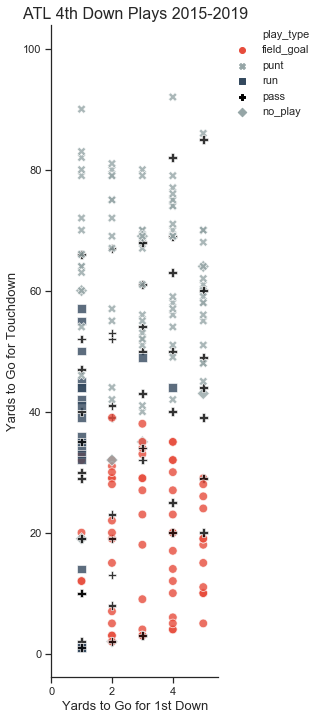

In [330]:
sns.set(rc={'figure.figsize':(3,12)})
sns.set_style("ticks")

cp = ["#e74c3c", "#95a5a6", "#34495e", "#000000",  "#95a5a6",]
sns.set_palette(cp)

sns.scatterplot(data=atl_4, y="yardline_100", x="ydstogo", hue='play_type', style='play_type', 
                s=75, alpha=0.8)

sns.despine()
plt.title('ATL 4th Down Plays 2015-2019', fontsize=16)
plt.xlabel('Yards to Go for 1st Down', fontsize=13)
plt.ylabel('Yards to Go for Touchdown', fontsize=13)
plt.xlim(0,5.5)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False)

plt.savefig(fname='figures/Fourth Down Plays_zoomed in2', bbox_inches='tight')

In [331]:
down_4_20 = pd.pivot_table(atl_4[atl_4['ydstogo'] <=5], index='play_type', values='down_4.0', aggfunc='count')
down_4_20

,down_4.0
play_type,
field_goal,68
no_play,8
pass,45
punt,85
run,21
